In [ ]:
import numpy as np
import cirq

pi = np.pi

In [2]:
def apply_noisy_logical_rz(circuit, qubit, angle, error_rate):
    """
    Replaces your 'BLIND GATE' rz with a noisy placeholder.
    Stim ignores the angle but simulates the error_rate.
    """
    # Represent the black-box error of the rotation
    circuit.append(cirq.depolarize(error_rate)(qubit))
    # Note: We do NOT append the actual rz(angle) because Stim 
    # cannot simulate non-stabilizer rotations.

Define functions for gate construction


In [20]:
# PhasedISWAP pow gate
def NoisyPhISwap(circuit, ctrl_qubit, tar_qubit, t, blind_error_rate):
    """
    Applies a PhasedISwap gate to the specified control and target qubits.
    t = exponent on the ISwap gate
    """
    # Stabilizer parts of PhISwap
    circuit.append(cirq.S(tar_qubit)**-1)
    circuit.append(cirq.H(ctrl_qubit))
    circuit.append(cirq.H(tar_qubit))
    circuit.append(cirq.CNOT(ctrl_qubit, tar_qubit))
    apply_noisy_logical_rz(circuit, tar_qubit, -pi/2 * t, blind_error_rate) # BLIND GATE
    circuit.append(cirq.CNOT(ctrl_qubit, tar_qubit))
    circuit.append(cirq.H(ctrl_qubit))
    circuit.append(cirq.H(tar_qubit))
    circuit.append(cirq.S(ctrl_qubit)**-1)
    circuit.append(cirq.S(tar_qubit))
    circuit.append(cirq.H(ctrl_qubit))
    circuit.append(cirq.H(tar_qubit))
    circuit.append(cirq.CNOT(ctrl_qubit, tar_qubit))
    apply_noisy_logical_rz(circuit, tar_qubit, pi/2 * t, blind_error_rate) # BLIND GATE
    circuit.append(cirq.CNOT(ctrl_qubit, tar_qubit))
    circuit.append(cirq.H(ctrl_qubit))
    circuit.append(cirq.H(tar_qubit))
    circuit.append(cirq.S(ctrl_qubit))

def NoisyZPow(circuit, qubit, q, blind_error_rate):
    """
    Applies a Z gate to the specified qubit with exponent q.
    """
    apply_noisy_logical_rz(circuit, qubit, pi * q, blind_error_rate) # BLIND GATE

def NoisyGivensRot(circuit, ctrl_qubit, tar_qubit, t, given_qubit, q, blind_error_rate):
    """
    Applies a Givens rotation to the specified control and target qubits (PhISwap followed by ZPow gate).
    """
    NoisyPhISwap(circuit, ctrl_qubit, tar_qubit, t, blind_error_rate)  # Apply PhasedISwap gate
    # NoisyZPow(circuit, given_qubit, q, blind_error_rate)  # Apply Z gate to given qubit

def NoisyCZPow(circuit, ctrl_qubit, tar_qubit, r, blind_error_rate):
    """
    Applies a CZ gate to the specified control and target qubits with exponent r.
    """
    circuit.append(cirq.CNOT(ctrl_qubit, tar_qubit)) 
    apply_noisy_logical_rz(circuit, tar_qubit, -pi/2 * r, blind_error_rate) # BLIND GATE
    circuit.append(cirq.CNOT(ctrl_qubit, tar_qubit))
    apply_noisy_logical_rz(circuit, ctrl_qubit, pi/2 * r, blind_error_rate) # BLIND GATE
    apply_noisy_logical_rz(circuit, tar_qubit, pi/2 * r, blind_error_rate) # BLIND GATE

def NoisySwapNetGate(circuit, ctrl_qubit, tar_qubit, r, blind_error_rate):
    """
    Applies a swap network gate to the specified control and target qubits with exponent r.
    """
    NoisyCZPow(circuit, ctrl_qubit, tar_qubit, r, blind_error_rate)
    circuit.append(cirq.SWAP(ctrl_qubit, tar_qubit))  # Apply SWAP gate between control and target qubits)

def BasisChange(circuit, qubits, basis_num, diag_phase, t, q, blind_error_rate):
    """
    Applies a basis change to the circuit.
    n: number of qubits
    diag_phase: phase for the diagonal gate
    t: exponent for the ISwap gate
    q: exponent for the Z gate
    """
    n = len(qubits)
    param_index = 0

    # Apply diagonal phase shifts
    for i in range(n):
        apply_noisy_logical_rz(circuit, qubits[i], diag_phase[i], blind_error_rate) # BLIND GATE

    # Apply Givens rotations
    for k in range(2 * (n - 1) - 1):
        if k < n - 1:
            start_row = 0
            start_col = n - 1 - k
        else:
            start_row = k - (n - 2)
            start_col = k - (n - 3)
        
        column_indicies = range(start_col, n, 2)
        row_indicies = range(start_row, start_row + len(column_indicies))
        indicies_to_zero_out = zip(row_indicies, column_indicies)

        for _, j in indicies_to_zero_out:
            
            if basis_num == 3: # For 3rd basis change, the structure is upside down
                ctrl_qubit = qubits[n - j]
                tar_qubit = qubits[n - j - 1]
            else:
                ctrl_qubit = qubits[j - 1]
                tar_qubit = qubits[j]
            given_qubit = tar_qubit
            NoisyGivensRot(circuit, ctrl_qubit, tar_qubit, t[param_index], given_qubit, q[param_index], blind_error_rate)
            param_index += 1

def global_eigenvalues(circuit, eigenvalue):
    """
    simulates global eigenvalues
    eigenvalue = -eigenvalues * time
    """
    for i in range(len(eigenvalue)):
        circuit.append(cirq.global_phase_operation(np.exp(1j * eigenvalue[i] / 2)))

    # eigenvalue = sum(eigenvalue)
    # circuit.append(cirq.global_phase_operation(np.exp(1j * eigenvalue / 2)))

def one_body_eigenvalues(circuit, qubits, eigenvalues, blind_error_rate):
    """
    simulates one body term eigenvalues
    """
    for i in range(len(qubits)):
        apply_noisy_logical_rz(circuit, qubits[i], eigenvalues[i], blind_error_rate) # BLIND GATE

def SwapNetwork(circuit, qubits, r, blind_error_rate):
    """
    constructs a swap network with swap gates
    """
    n = len(qubits)
    param_index = 0

    for layer in range(n):
        if layer % 2 == 0:
            for i in range(0, n - 1, 2):
                NoisySwapNetGate(circuit, qubits[i], qubits[i + 1], r[param_index], blind_error_rate)
                param_index += 1
        else:
            for i in range(1, n - 1, 2):
                NoisySwapNetGate(circuit, qubits[i], qubits[i + 1], r[param_index], blind_error_rate)
                param_index += 1

Define a function for constructing a general circuit (have not optimized and made it versatile to the # of qubits)

In [21]:
def create_Low_Rank_Trotter_circuit(circuit, qubits, BC1, BC2, BC3, BC4, eigenvalues, r_1, r_2, blind_error_rate):
    """
    Constructs a general circuit for Hamiltonian simulation using Givens rotations and swap networks.
    """
    # Unpack basis change parameters
    diag_phase_1 = BC1[0]
    t_1 = BC1[1]
    q_1 = BC1[2]
    diag_phase_2 = BC2[0]
    t_2 = BC2[1]
    q_2 = BC2[2]
    diag_phase_3 = BC3[0]
    t_3 = BC3[1]
    q_3 = BC3[2]
    diag_phase_4 = BC4[0]
    t_4 = BC4[1]
    q_4 = BC4[2]

    # Construct the general circuit for Hamiltonian simulation
    BasisChange(circuit, qubits, 1, diag_phase_1, t_1, q_1, blind_error_rate) # First basis change
    # global_eigenvalues(circuit, eigenvalues)  # Apply global eigenvalues
    one_body_eigenvalues(circuit, qubits, eigenvalues, blind_error_rate)  # Apply one-body eigenvalues
    BasisChange(circuit, qubits, 2, diag_phase_2, t_2, q_2, blind_error_rate)  # Second basis change
    SwapNetwork(circuit, qubits, r_1, blind_error_rate)  # First swap network
    BasisChange(circuit, qubits, 3, diag_phase_3, t_3, q_3, blind_error_rate)  # Third basis change
    SwapNetwork(circuit, qubits, r_2, blind_error_rate)  # Second swap network
    BasisChange(circuit, qubits, 4, diag_phase_4, t_4, q_4, blind_error_rate)  # Fourth basis change
    # print(circuit)


In [ ]:
import stim 
import stimcirq

def generate_qec_chemistry_circuit(distance, physical_error_rate, BC1, BC2, BC3, BC4, eigenvalues, r_1, r_2, blind_error_rate):
    """
    Integrates the chemistry algorithm into a surface code simulation.
    """
    # 1. Create the base 'Memory' rounds to stabilize qubits first
    # This sets up the physical grid and the initial detection events

    stim_circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=distance,
        rounds=distance, # We run d rounds of syndrome extraction
        after_clifford_depolarization=physical_error_rate
    )
    
    # 2. Build your Algorithm Layer in Cirq
    # We use a helper to get the physical qubits that correspond to 
    # the 'Logical' qubits in the surface code patch
    qubits = cirq.LineQubit.range(6)
    algorithm_circuit = cirq.Circuit()

    # Call your function (using the noisy Rz placeholders we discussed)
    # We pass 'physical_p' so the algorithm gates have the same noise level
    create_Low_Rank_Trotter_circuit(algorithm_circuit, qubits, BC1, BC2, BC3, BC4, eigenvalues, r_1, r_2, physical_error_rate)  # Create the circuit

    # 3. Convert the algorithm to Stim and append it
    stim_algo = stimcirq.cirq_circuit_to_stim_circuit(algorithm_circuit)
    stim_circuit += stim_algo

    # 4. Add more syndrome rounds to catch errors that happened during the gates
    post_gate_rounds = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=distance,
        rounds=2,
        after_clifford_depolarization=physical_error_rate
    )
    stim_circuit += post_gate_rounds


    return stim_circuit

In [35]:
import pymatching

def test_algorithm_threshold(distance, p, BC1, BC2, BC3, BC4, eigenvalues, r_1, r_2, blind_error_rate):
    circuit = generate_qec_chemistry_circuit(distance, p, BC1, BC2, BC3, BC4, eigenvalues, r_1, r_2, blind_error_rate)
    
    # The Detector Error Model (DEM) explains how errors in your 
    # chemistry gates trigger the surface code detectors
    dem = circuit.detector_error_model(decompose_errors=True)
    matching = pymatching.Matching.from_detector_error_model(dem)
    
    sampler = circuit.compile_detector_sampler()
    defects, actual_errors = sampler.sample(shots=10000, separate_observables=True)
    
    predictions = matching.decode_batch(defects)
    logical_errors = np.any(predictions != actual_errors, axis=1)
    
    return np.mean(logical_errors)

Define Molecule

In [36]:
from openfermion import get_fermion_operator, jordan_wigner, get_sparse_operator
from openfermionpyscf import generate_molecular_hamiltonian
from pyscf import gto, scf

# Define the number of qubits
num_qubits = 6

# Hydrogen Chain MOLECULE
# num_hydrogens = 2
# distance = 1.2 
# atom_coordinates = [f"H {i * distance} 0 0" for i in range(num_hydrogens)]
# mol = gto.Mole()
# mol.atom =  "; ".join(atom_coordinates)
# mol.basis = 'sto-3g'
# mol.charge = 0
# mol.spin = num_hydrogens % 2
# mol.build()

# LiH MOLECULE
distance = 1.6
mol = gto.Mole()
mol.atom = f"Li 0 0 0; H 0 0 {distance}" # Lithium hydride molecule
mol.basis = "sto-3g" #'cc-pv5z' 'cc-pvqz'  #These are the different choices of atomic orbitals to include in the calculation
mol.charge = 0 #electric charge sector
mol.spin = 0 #S_z sector
mol.build()

# He_2 MOLECULE
# distance = 2.0
# mol = gto.Mole()
# mol.atom = f"He 0 0 0; He 0 0 {distance}"  # Helium dimer molecule
# mol.basis = 'sto-3g'
# mol.charge = 0  # Electric charge sector
# mol.spin = 0  # S_z sector
# mol.build()

# BeH_2 MOLECULE (6 qubits)
# distance = 1.33
# mol = gto.Mole() 
# mol.atom = f"Be 0 0 0; H {distance} 0 0; H -{distance} 0 0"
# mol.basis = "sto-3g" #'cc-pv5z' 'cc-pvqz'  #These are the different choices of atomic orbitals to include in the calculation
# mol.charge = 0 #electric charge sector
# mol.spin = 0 #S_z sector
# mol.build()

# Perform Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()

# Generate the molecular Hamiltonian
mol_ham = generate_molecular_hamiltonian(mol.atom,
        mol.basis,
        multiplicity = mol.spin + 1,
        charge = mol.charge,
        n_active_electrons=2,
        n_active_orbitals=2
)

mol.ao_labels()

converged SCF energy = -7.86186476980865


['0 Li 1s    ',
 '0 Li 2s    ',
 '0 Li 2px   ',
 '0 Li 2py   ',
 '0 Li 2pz   ',
 '1 H 1s    ']

In [37]:
# Jordan-Wigner transformation
H_fermi = get_fermion_operator(mol_ham)
print("number of terms: " + str(len(H_fermi.terms)))

qubit_hamiltonian = jordan_wigner(H_fermi)     # Convert the fermionic Hamiltonian to a qubit Hamiltonian using Jordan-Wigner transformation

# Print the qubit Hamiltonian
print("Qubit Hamiltonian:")
print(qubit_hamiltonian)

# Step 5: (Optional) Convert to a sparse matrix for simulation
H_mat = get_sparse_operator(qubit_hamiltonian).toarray()

number of terms: 73
Qubit Hamiltonian:
(-3.8006076768459764+0j) [] +
(-0.002137377016341704+0j) [X0 X1 Y2 Y3] +
(0.002137377016341704+0j) [X0 Y1 Y2 X3] +
(-0.004844443306154697+0j) [X0 Z1 X2] +
(-0.0132612556867148+0j) [X0 Z1 X2 Z3] +
(0.0007670968646192311+0j) [X0 X2] +
(0.002137377016341704+0j) [Y0 X1 X2 Y3] +
(-0.002137377016341704+0j) [Y0 Y1 X2 X3] +
(-0.004844443306154697+0j) [Y0 Z1 Y2] +
(-0.0132612556867148+0j) [Y0 Z1 Y2 Z3] +
(0.0007670968646192311+0j) [Y0 Y2] +
(0.18330834423430795+0j) [Z0] +
(0.0007670968646192311+0j) [Z0 X1 Z2 X3] +
(0.0007670968646192311+0j) [Z0 Y1 Z2 Y3] +
(0.11344680274916535+0j) [Z0 Z1] +
(0.08829538599842374+0j) [Z0 Z2] +
(0.09043276301476544+0j) [Z0 Z3] +
(-0.004844443306154701+0j) [X1 Z2 X3] +
(-0.013261255686714797+0j) [X1 X3] +
(-0.004844443306154701+0j) [Y1 Z2 Y3] +
(-0.013261255686714797+0j) [Y1 Y3] +
(0.18330834423430795+0j) [Z1] +
(0.09043276301476544+0j) [Z1 Z2] +
(0.08829538599842374+0j) [Z1 Z3] +
(1.7703267431810716+0j) [Z2] +
(0.414641671714

Construct Circuit

In [38]:
# qubits = cirq.LineQubit.range(num_qubits) 
# circuit = cirq.Circuit()  # Initialize an empty circuit
time = 0.5

# PARAMETERS FOR H_2 (0.5s)
# BC1 = ([0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC2 = ([0, 0, 0, 0], [-1.0, -1.0, -1.0, -1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC3 = ([-0.047 * pi, -0.047 * pi + pi, -0.047 * pi + pi, -0.047 * pi], [-1.0, -0.5, 0.5, -1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC4 = ([-0.017 * pi + pi, -0.017 * pi, -0.017 * pi + pi, -0.017 * pi], [-1.0, -0.5, 0.5, -1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# eigenvalues = [0.226 * pi, 0.226 * pi, 0.167 * pi, 0.167 * pi] 
# r_1 = [-0.098, -0.093, -0.096, -0.096, -0.096, -0.096]
# r_2 = [-0.033, -0.033, 0.033, 0.033, 0.033, 0.033]

# PARAMETERS FOR H_3 (0.5s)
# BC1 = ([0, pi, 0, 0, 0, pi], [0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.131, 0.131, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.835], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0,0, 0,0, 0,0, 0,0, 0,0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC2 = ([0, pi, pi, pi, pi, 0], [-0.835, -1.0, -1.0, -1.0, -1.0, -1.0, -0.449, 0.449, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0],  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0,0, 0,0, 0,0, 0,0, 0,0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC3 = ([-0.034 * pi, -0.034 * pi, -0.035 * pi, -0.035 * pi + pi, -0.052 * pi, -0.052 * pi + pi], [0.0, -1.0, 0.497, 0.497, -1.0, -1.0, 0.943, 0.943, 0.0, -1.0, -1.0, 0.057, -0.057, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0,0, 0,0, 0,0, 0,0, 0,0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC4 = ([-0.024 * pi, -0.024 * pi + pi, pi, 0.0, -0.024 * pi + pi, -0.024 * pi + pi], [0.0, -1.0, -0.391, -0.391, -1.0, -1.0, 2/3, 2/3, 0.0, -1.0, -1.0, -0.392, 0.392, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0,0, 0,0, 0,0, 0,0, 0,0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# eigenvalues = [0.288 * pi, 0.288 * pi, 0.237 * pi, 0.237 * pi, 0.196 * pi, 0.196 * pi] 
# r_1 = [-0.103, -0.069, -0.069, -0.085, -0.069, -0.085, -1/12, -0.069, -1/12, -1/12, -0.069, -1/12, -0.085, -0.069, -0.085]
# r_2 = [-0.048, 0.0, -0.048, 0.0, 0.0, 0.0, 0.048, 0.0, 0.048, 0.048, 0.0, 0.048, 0.0, 0.0, 0.0]

# PARAMETERS FOR LiH for 6 qubits (0.5s)
# BC1 = ([0.0, pi, pi, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.991, -0.991, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC2 = ([0.0, pi, pi, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -0.018, 0.018, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC3 = ([0.0, 0.0, -0.01 * pi, -0.01 * pi + pi, -0.13 * pi, -0.13 * pi + pi], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC4 = ([-0.002 * pi + pi, -0.002 * pi, -0.026 * pi + pi, -0.026 * pi, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -0.974, 0.974, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# eigenvalues = [0.885 * pi, 0.885 * pi, 0.188 * pi, 0.188 * pi, 0.0, 0.0]
# r_1 = [-0.261, -0.02, 0.0, -1/14, 0.0, -1/14, -1/14, 0.0, -1/14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# r_2 = [0.0, -0.053, -0.004, 0.0, 0.014, 0.0, 0.014, 0.014, 0.0, 0.014, 0.0, 0.0, 0.0, 0.0, 0.0]

# PARAMETERS FOR LiH for 6 qubits (time variant)
BC1 = ([0.0, pi, pi, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.991, -0.991, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
BC2 = ([0.0, pi, pi, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -0.018, 0.018, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
BC3 = ([0.0, 0.0, -0.02 * pi * time, -0.02 * pi * time + pi, -0.261 * pi * time, -0.261 * pi * time + pi], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
BC4 = ([-0.004 * pi * time + pi, -0.004 * pi * time, -0.053 * pi * time + pi, -0.053 * pi * time, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -0.974, 0.974, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
eigenvalues = [1.77 * pi * time, 1.77 * pi * time, 0.376 * pi * time, 0.376 * pi * time, 0.0, 0.0]
r_1 = [-0.521 * time, -0.039 * time, 0.0, -1/7 * time, 0.0, -1/7 * time, -1/7 * time, 0.0, -1/7 * time, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
r_2 = [0.0, -0.105 * time, -0.008 * time , 0.0, 0.029 * time, 0.0, 0.029 * time, 0.029 * time, 0.0, 0.029 * time, 0.0, 0.0, 0.0, 0.0, 0.0]

# PARAMETERS FOR LiH for 4 qubits (0.5s)
# BC1 = ([0, pi, pi, 0], [0.0, -1.0, 0.991, -0.991, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC2 = ([0, pi, pi, 0], [0.0, -1.0, -0.018, 0.018, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC3 = ([-0.01 * pi, -0.01 * pi + pi, -0.13 * pi, -0.13 * pi + pi], [0.0, -1.0, 0.0, 0.0, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC4 = ([-0.002 * pi + pi, -0.002 * pi, -0.026 * pi + pi, -0.026 * pi], [0.0, -1.0, -0.974, 0.974, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# eigenvalues = [0.885 * pi, 0.885 * pi, 0.188 * pi, 0.188 * pi]
# r_1 = [-0.261, -0.02, -1/14, -1/14, -1/14, -1/14]
# r_2 = [-0.053, -0.004, 0.014, 0.014, 0.014, 0.014]

# PARAMETERS FOR He_2 for 6 qubits (0.5s)
# BC1 = ([0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC2 = ([0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC3 = ([0.0, 0.0, -0.052 * pi + pi, -0.052 * pi, -0.053 * pi, -0.053 * pi + pi], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.5, -0.5, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC4 = ([-0.032 * pi + pi, -0.032 * pi, -0.032 * pi + pi, -0.032 * pi, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -0.5, 0.5, 0.0, -1.0, 0.0, 0.0, 0,0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# eigenvalues = [0.477 * pi, 0.477 * pi, 0.474 * pi, 0.474 * pi, 0.0, 0.0] 
# r_1 = [-0.106, -0.104, 0.0, -0.105, 0.0, -0.105, -0.105, 0.0, -0.105, 0,0, 0,0, 0,0, 0,0, 0.0, 0.0] 
# r_2 = [0.0, -1/16, -1/16, 0.0, 1/16, 0.0, 1/16, 1/16, 0.0, 1/16, 0.0, 0.0, 0.0, 0.0, 0.0] 


# PARAMETERS FOR He_2 for 4 qubits (0.5s)
# BC1 = ([0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC2 = ([0, 0, 0, 0], [ 0.0, -1.0, -1.0, -1.0, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC3 = ([-0.052 * pi + pi, -0.052 * pi, -0.053 * pi, -0.053 * pi + pi], [0.0, -1.0, 0.5, -0.5, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC4 = ([-0.032 * pi + pi, -0.032 * pi, -0.032 * pi + pi, -0.032 * pi], [0.0, -1.0, -0.5, 0.5, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# eigenvalues = [0.477 * pi, 0.477 * pi, 0.474 * pi, 0.474 * pi] 
# r_1 = [-0.106, -0.104, -0.105, -0.105, -0.105, -0.105] 
# r_2 = [-1/16, -1/16, 1/16, 1/16, 1/16, 1/16] 

# Identity parameters 
# BC1 = ([0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC2 = ([0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC3 = ([0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC4 = ([0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# eigenvalues = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# r_1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# r_2 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# PARAMETERS FOR BeH_2 for 6 qubits (0.5s)
# BC1 = ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC2 = ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC3 = ([-0.031 * pi, -0.031 * pi, -0.031 * pi, -0.031 * pi + pi, -0.037 * pi + pi, -0.037 * pi], [0.0, -1.0, -0.5, 0.5, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# BC4 = ([-0.011 * pi, -0.011 * pi + pi, 0.0, 0.0, -0.011 * pi, -0.011 * pi + pi], [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -0.5, 0.5, -1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# eigenvalues = [0.407 * pi, 0.407 * pi, 0.353 * pi, 0.353 * pi, 0.338 * pi, 0.338 * pi]
# r_1 = [-0.074, -1/16, -1/16, -0.068, -1/16, -0.068, -0.068, -1/16, -0.068, -0.068, -1/16, -0.068, -0.068, -1/16, -0.068]
# r_2 = [-0.022, 0.0, -0.022, 0.0, 0.0, 0.0, 0.022, 0.0, 0.022, 0.022, 0.0, 0.022, 0.0, 0.0, 0.0]

# Create the circuit using the defined parameters
# create_Low_Rank_Trotter_circuit(circuit, qubits, BC1, BC2, BC3, BC4, eigenvalues, r_1, r_2, 0.01)  # Create the circuit

# print(circuit)


Starting simulation...
Simulating Distance d=3
  p=0.0010 -> Logical Error Rate: 0.0001
  p=0.0019 -> Logical Error Rate: 0.0015
  p=0.0037 -> Logical Error Rate: 0.0041
  p=0.0072 -> Logical Error Rate: 0.0169
  p=0.0139 -> Logical Error Rate: 0.0518
  p=0.0268 -> Logical Error Rate: 0.1510
  p=0.0518 -> Logical Error Rate: 0.3415
  p=0.1000 -> Logical Error Rate: 0.4773
Simulating Distance d=5
  p=0.0010 -> Logical Error Rate: 0.0000
  p=0.0019 -> Logical Error Rate: 0.0003
  p=0.0037 -> Logical Error Rate: 0.0021
  p=0.0072 -> Logical Error Rate: 0.0122
  p=0.0139 -> Logical Error Rate: 0.0693
  p=0.0268 -> Logical Error Rate: 0.2711
  p=0.0518 -> Logical Error Rate: 0.4745
  p=0.1000 -> Logical Error Rate: 0.4986
Simulating Distance d=7
  p=0.0010 -> Logical Error Rate: 0.0000
  p=0.0019 -> Logical Error Rate: 0.0000
  p=0.0037 -> Logical Error Rate: 0.0005
  p=0.0072 -> Logical Error Rate: 0.0092
  p=0.0139 -> Logical Error Rate: 0.0846
  p=0.0268 -> Logical Error Rate: 0.3464
  p

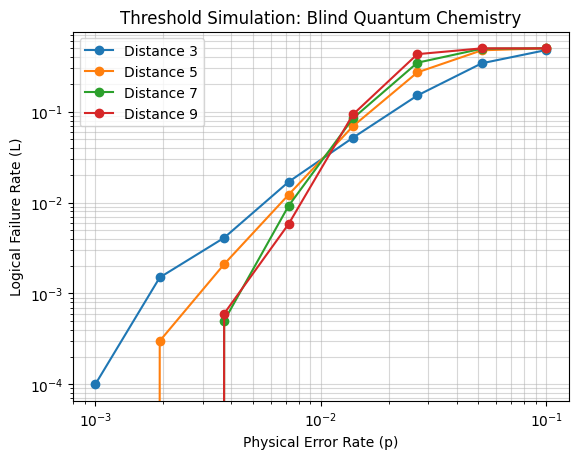

In [40]:
import matplotlib.pyplot as plt


# Define the range of distances and physical error rates to test
distances = [3, 5, 7, 9]
physical_p_rates = np.logspace(-3, -1, 8) # From 0.001 to 0.1

# Dictionary to store results
threshold_results = {d: [] for d in distances}

print("Starting simulation...")
for d in distances:
    print(f"Simulating Distance d={d}")
    for p in physical_p_rates:
        # Call the function for this specific d and p
        # We pass the chemistry parameters into the internal call
        error_rate = test_algorithm_threshold(d, p, BC1, BC2, BC3, BC4, eigenvalues, r_1, r_2, 0.01)
        threshold_results[d].append(error_rate)
        print(f"  p={p:.4f} -> Logical Error Rate: {error_rate:.4f}")

# 3. Plotting the results
plt.figure()
for d in distances:
    plt.plot(physical_p_rates, threshold_results[d], label=f"Distance {d}", marker='o')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Physical Error Rate (p)")
plt.ylabel("Logical Failure Rate (L)")
plt.title("Threshold Simulation: Blind Quantum Chemistry")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

Solve for exact solution

In [31]:
# Define the initial state for the simulation
from openfermion import haar_random_vector
from scipy.sparse.linalg import expm_multiply, expm
import qutip as qt
from numpy import linalg

initial_state = haar_random_vector(2**4, 1234).astype(np.complex64)
initial_state_6 = np.kron(initial_state, np.array([1, 0, 0, 0], dtype=initial_state.dtype))

exact_state_4 = expm_multiply(-1j*time*H_mat, initial_state)

# U tensor I_2
U_exact_4 = expm(-1j * time * H_mat)
I_2 = np.eye(4, dtype=complex)
U_exact_6 = np.kron(U_exact_4, I_2)

# 6 qubit H_mat = H_mat_4 tensor I_2
H_mat_6 = np.kron(H_mat, I_2)
exact_state_6 = expm_multiply(-1j*time*H_mat_6, initial_state_6)

exact_state_qobj = qt.Qobj(exact_state_4, dims=[[2]*4, [1]*4])
initial_state_qobj = qt.Qobj(initial_state, dims=[[2]*4, [1]*4])  


# print(np.abs(np.vdot(exact_state_4, initial_state)))
print(qt.metrics.fidelity(exact_state_qobj, initial_state_qobj))

0.6355552842136774


In [32]:
# Use Cirq's simulator to run the circuit
simulator = cirq.Simulator()
if num_qubits == 4:
    result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_state)
    simulated_state = result.final_state_vector
    
    simulate_state_rho_qobj = qt.Qobj(simulated_state, dims=[[2]*4, [1]*4])
    print("Fidelity between simulated_4_state & intial_state_4: ", qt.metrics.fidelity(simulate_state_rho_qobj, initial_state_qobj))

else:
    result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_state_6)
    simulated_state = result.final_state_vector


    simulate_state_rho_6 = qt.Qobj(np.outer(simulated_state, simulated_state.conj()), dims=[[2]*6, [2]*6])
    simulate_state_rho_qobj = qt.ptrace(simulate_state_rho_6,[0,1,2,3])
    simulated_ancilla_state_trace = qt.ptrace(simulate_state_rho_6,[4,5])

    print("simulated_state_4 rank: ", np.linalg.matrix_rank(simulate_state_rho_qobj))
    print("simulated_state_ancilla rank: ", np.linalg.matrix_rank(simulated_ancilla_state_trace))

    ket_00_qobj = qt.Qobj(np.array([1, 0, 0, 0], dtype=initial_state.dtype), dims=[[2]*2, [1]*2])  

    print("Fidelity between simulated_4_state & intial_state_4: ", qt.metrics.fidelity(simulate_state_rho_qobj, initial_state_qobj))
    print("Fidelity between ancilla state & ket 00: ", qt.metrics.fidelity(simulated_ancilla_state_trace, ket_00_qobj))

simulated_state_4 rank:  1
simulated_state_ancilla rank:  1
Fidelity between simulated_4_state & intial_state_4:  0.5913100896988202
Fidelity between ancilla state & ket 00:  1.000000069267114


Compare fidelity

In [33]:
# fidelity = np.abs(np.vdot(simulated_state, exact_state))**2
fidelity = qt.metrics.fidelity(simulate_state_rho_qobj, exact_state_qobj)
print('Trotter Step Fidelity: ',fidelity)

Trotter Step Fidelity:  0.9923037570737743


In [34]:
print(simulated_state)
print(exact_state_6)

[-1.2649356e-02+0.11091054j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
  2.2008334e-01-0.00659687j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
 -2.0174956e-01-0.28456295j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
 -2.8572524e-01-0.00250344j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
  2.4567354e-02-0.13184205j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
 -1.9605228e-01+0.02824016j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
 -1.1282316e-01-0.10297596j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
  7.1295269e-02+0.1442413j   0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
 -2.3686545e-01+0.02513207j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
  2.5466749e-01+0.31677514j  0.0000000e+00+0.j
  0.0000000e+00-0.j          0.0000000e+00+0.j
 -8.5963599e-02-0.2234818j   0.0000000e+00+0.j
  0.0000000e+

In [35]:
ratio = simulated_state/exact_state_6
print(ratio)
print(np.angle(ratio[0]))
# ratio_new = ratio[~np.isnan(ratio)]
# print(ratio_new)

[ 0.1004617 +0.99494229j         nan       +nanj         nan       +nanj
         nan       +nanj  0.09649251+0.9923519j          nan       +nanj
         nan       +nanj         nan       +nanj  0.09711745+0.99102579j
         nan       +nanj         nan       +nanj         nan       +nanj
  0.05563664+1.02441097j         nan       +nanj         nan       +nanj
         nan       +nanj  0.09217596+1.00390915j         nan       +nanj
         nan       +nanj         nan       +nanj  0.10188869+0.99479522j
         nan       +nanj         nan       +nanj         nan       +nanj
  0.05980983+0.96671096j         nan       +nanj         nan       +nanj
         nan       +nanj  0.14648131+1.04409833j         nan       +nanj
         nan       +nanj         nan       +nanj  0.09570046+1.00470423j
         nan       +nanj         nan       +nanj         nan       +nanj
 -0.09641536+0.98446814j         nan       +nanj         nan       +nanj
         nan       +nanj -0.07670442+0.99705363j   

/var/folders/n7/h6rz1hj97pd97gjpbkd6ss640000gn/T/ipykernel_51734/504011133.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = simulated_state/exact_state_6


Operator norm of an error

In [36]:
U_simulated = cirq.unitary(circuit)
error = U_exact_6 - U_simulated

svd_error = np.linalg.svd(error)[1].max()
print(svd_error) # largest singular value

1.5854628071308174
